## *Базовая обработка и анализ текста* 

In [1]:
#remove irritating warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#importing libraries
import numpy as np 
import pandas as pd
import spacy 
import re
from collections import Counter 

In [3]:
#importing data
data = pd.read_csv('financial_review.csv')

In [4]:
data.head(2)

,bank_href,login,review,bank_name,site,date,message_href,score,status,user_href
0,/kredit-evropa-bank.html,NaN,"Брал кредит в данной организации, после погаше...",кредит европа банк,http://bankireview.ru,NaN,NaN,NaN,NaN,NaN
1,/kredit-evropa-bank.html,NaN,"В 2011 году,мною была оформлена мега карта в Т...",кредит европа банк,http://bankireview.ru,NaN,NaN,NaN,NaN,NaN


In [5]:
#filtering reviews by bank name
reviews = data[data.bank_name == 'тинькофф банк'][['review', 'score']]

In [6]:
nlp = spacy.load('ru_core_news_sm')

In [7]:
#function for cleaning data 
def cleaningdata(text):
    #delete punctuation and another not alphanumeric symbols 
    text = re.sub(r'[^\w\s]', ' ', text)
    #delete digitals 
    text = re.sub(r'[\d]', ' ', text)
    #delete extra whitespace 
    text = re.sub(r'\s+', ' ', text)
    #transform to lower-case 
    text = text.lower()
    text = nlp(text)
    #lemmatisation and deleting stop-words 
    tokens = [token.lemma_ for token in text if token.is_stop == False]
    text = " ".join(tokens)
    return text

In [8]:
reviews['review'] = reviews['review'].apply(cleaningdata)

In [9]:
#quick look on result 
reviews.head(2)

,review,score
2487,финансами плохо работа муж постоянный доход бо...,NaN
2488,вчера закрывать задолженность карта тинькофф о...,NaN


In [10]:
#for comparing
data[data.bank_name == 'тинькофф банк'][['review', 'score']].head(2)

,review,score
2487,"С финансами было все не плохо,была работа у му...",NaN
2488,Вчера закрывал задолженность по карте Тинькофф...,NaN


In [11]:
#top 10 most common words 
Counter(reviews.review.sum().split()).most_common()[0:10]

[('банк', 4977),
 ('карта', 2236),
 ('тинькофф', 1407),
 ('счёт', 1044),
 ('день', 911),
 ('клиент', 831),
 ('вопрос', 794),
 ('сотрудник', 779),
 ('деньга', 726),
 ('год', 712)]

In [12]:
#how many NaN values we have in a score column as a percentage? 
f'{np.round(reviews.score.isnull().sum()/reviews.score.shape[0]*100, 1)}%'

'7.9%'

In [13]:
#what other values do we have?
reviews['score'].unique()

array([nan, '5', 'Без оценки', '2', '3', '1', '4'], dtype=object)

In [14]:
#how many "unrated" values we have in a score column as a percentage? 
f'{np.round(sum(reviews["score"] == "Без оценки")/reviews.score.shape[0]*100, 1)}%'

'14.6%'

In [15]:
#let's fill none-values and "unrated" values with an average score 
reviews.loc[reviews.score == 'Без оценки', 'score'] = 0 
reviews['score'] = pd.to_numeric(reviews['score'])
reviews.loc[reviews.score == 0,'score'] = reviews['score'].mean()
reviews['score'] = reviews['score'].fillna(reviews['score'].mean())

In [16]:
#treshold for categorisation 
threshold = (reviews['score'].max() - reviews['score'].min())/2

In [17]:
#labeling
reviews['label'] = reviews['score'].apply(lambda x: 'positive'if x > threshold else 'negative')

In [18]:
#is our data balanced?
reviews.label.value_counts()

positive    1145
negative     331
Name: label, dtype: int64

In [19]:
#function for finding most common adjectives  
def popular_adjectives(emotional_reviews):
    text = nlp(emotional_reviews)
    tokens = [token.lemma_ for token in text if token.pos_ == 'ADJ']
    return Counter(tokens).most_common()[0:10]

In [20]:
#top-10 most common adjectives in positive reviews 
popular_adjectives(reviews[reviews.label == 'positive'].review.values.sum())

[('счёт', 432),
 ('кредитный', 395),
 ('хороший', 307),
 ('удобный', 294),
 ('дебетовый', 239),
 ('новый', 177),
 ('первый', 176),
 ('личный', 172),
 ('мобильный', 169),
 ('деньга', 147)]

In [21]:
#top-10 most common adjectives in negative reviews 
popular_adjectives(reviews[reviews.label == 'negative'].review.values.sum())

[('кредитный', 176),
 ('счёт', 154),
 ('дебетовый', 64),
 ('первый', 58),
 ('личный', 57),
 ('деньга', 50),
 ('новый', 46),
 ('следующий', 45),
 ('нужный', 40),
 ('тинькофф', 40)]

## *Частотные подходы* 

In [22]:
#importing everything we need 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

In [23]:
allreviews = data[['review', 'score']]

In [24]:
#let's again fill none-values and "unrated" values with an average score 
allreviews.loc[allreviews.score == 'Без оценки', 'score'] = 0 
allreviews['score'] = pd.to_numeric(allreviews['score'])
allreviews.loc[allreviews.score == 0,'score'] = allreviews['score'].mean()
allreviews['score'] = allreviews['score'].fillna(allreviews['score'].mean())

In [25]:
#labeling
allreviews['label'] = allreviews['score'].apply(lambda x: 'positive'if x > threshold else 'negative')

In [26]:
#from the previous lab we found out that our data is unbalanced 
#this can make the model more focused on positive values 
#let's fix it by under-sampling 
#plus my pc can't hadle all the data:))) 
positive = allreviews[allreviews.label == 'positive'].iloc[0:2000]
negative = allreviews[allreviews.label == 'negative'].iloc[0:2000]

In [27]:
#concatenating data 
balanced_data = pd.concat([positive, negative], ignore_index=True)

In [28]:
%%time
balanced_data['review'] = balanced_data['review'].apply(cleaningdata)

CPU times: user 3min 45s, sys: 7.98 s, total: 3min 53s
Wall time: 3min 53s


In [29]:
X = balanced_data.review 
y = balanced_data.label 

In [30]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [32]:
pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('forest', RandomForestClassifier())
])
pipeline2 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logreg', LogisticRegression())
])
pipeline3 = Pipeline([
    ('bow', CountVectorizer()),
    ('logreg', LogisticRegression())
])
pipeline4 = Pipeline([
    ('bow', CountVectorizer()),
    ('forest', RandomForestClassifier())
])

In [33]:
parameters1 = {
    'tfidf__max_df': (0.5, 0.75, 1.0),
    'tfidf__ngram_range': ((1, 1), (1, 2)),
    'forest__n_estimators': [100, 200, 300],
    'forest__max_depth': [5, 10, 20]
}
parameters2 = {
    'tfidf__max_df': (0.5, 0.75, 1.0),
    'tfidf__ngram_range': ((1, 1), (1, 2)),
    'logreg__C': [0.1, 1.0, 10.0]
}
parameters3 = {
    'bow__max_df': [0.5, 0.75, 1.0], 
    'bow__ngram_range': [(1, 1), (1, 2)],
    'logreg__C': [0.1, 1.0, 10.0]
}
parameters4 = {
    'bow__max_df': [0.5, 0.75, 1.0], 
    'bow__ngram_range': [(1, 1), (1, 2)],
    'forest__n_estimators': [100, 200, 300],
    'forest__max_depth': [5, 10, 20]
}

In [34]:
models = [pipeline1, pipeline2, pipeline3, pipeline4]
parameters = [parameters1, parameters2, parameters3, parameters4]

In [35]:
#finding hyperparams 
for model, parameter in zip(models, parameters):
    grid_search = GridSearchCV(model, parameter, cv=2, n_jobs=-1, verbose=1, error_score='raise')
    grid_search.fit(X_train, y_train)
    print(f"Best parameters for {list(parameter.keys())[0].split('__')[0]} + {list(parameter.keys())[2].split('__')[0]}:")
    print(grid_search.best_params_)
    y_pred = grid_search.predict(X_test)
    print(classification_report(y_test, y_pred))

Fitting 2 folds for each of 54 candidates, totalling 108 fits
Best parameters for tfidf + forest:
{'forest__max_depth': 20, 'forest__n_estimators': 300, 'tfidf__max_df': 1.0, 'tfidf__ngram_range': (1, 1)}
              precision    recall  f1-score   support

           0       0.74      0.77      0.75       492
           1       0.77      0.73      0.75       508

    accuracy                           0.75      1000
   macro avg       0.75      0.75      0.75      1000
weighted avg       0.75      0.75      0.75      1000

Fitting 2 folds for each of 18 candidates, totalling 36 fits
Best parameters for tfidf + logreg:
{'logreg__C': 10.0, 'tfidf__max_df': 0.5, 'tfidf__ngram_range': (1, 1)}
              precision    recall  f1-score   support

           0       0.79      0.76      0.78       492
           1       0.78      0.81      0.79       508

    accuracy                           0.79      1000
   macro avg       0.79      0.78      0.78      1000
weighted avg       0.79    

/Users/mariaisrafilova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mariaisrafilova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

Best parameters for bow + logreg:
{'bow__max_df': 0.75, 'bow__ngram_range': (1, 1), 'logreg__C': 0.1}
              precision    recall  f1-score   support

           0       0.76      0.77      0.76       492
           1       0.77      0.76      0.77       508

    accuracy                           0.76      1000
   macro avg       0.76      0.76      0.76      1000
weighted avg       0.76      0.76      0.76      1000

Fitting 2 folds for each of 54 candidates, totalling 108 fits
Best parameters for bow + forest:
{'bow__max_df': 0.75, 'bow__ngram_range': (1, 1), 'forest__max_depth': 20, 'forest__n_estimators': 300}
              precision    recall  f1-score   support

           0       0.77      0.87      0.81       492
           1       0.85      0.75      0.80       508

    accuracy                           0.81      1000
   macro avg       0.81      0.81      0.80      1000
weighted avg       0.81      0.81      0.80      1000



По результатм видно, что лучше всего с классификацией справилась модель случайного леса с bag of words векторезацией, в которой использовались все униграммы. 

## *Тематическое моделирование* 

In [36]:
#importing all we need 
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
import seaborn as sns 

In [37]:
#most common banks 
data.bank_name.value_counts()

втб                             2603
сбербанк                        2481
тинькофф банк                   1476
почта банк                      1264
альфа-банк                      1260
                                ... 
национальный банк сбережений       1
электронный платежный сервис       1
внешфинбанк                        1
металлург                          1
банк развитие-столица              1
Name: bank_name, Length: 475, dtype: int64

In [38]:
topic_data = data[data.bank_name == 'сбербанк']['review']

In [39]:
topic_data = topic_data.apply(cleaningdata)

In [40]:
def tokens(text):
    text = nlp(text)
    tokens = [token.lemma_ for token in text if token.is_stop == False]
    return tokens

In [41]:
topic_data = topic_data.apply(tokens)

In [42]:
dictionary = corpora.Dictionary(topic_data.values)
doc_term_matrix = [dictionary.doc2bow(review) for review in topic_data.values]

In [69]:
#let's try 3-10 topics and see does it make sense or not
perplexity_list = []
coherence_list = []
for n_topics in range(3, 10):
    print(f'Number of topics: {n_topics}')
    lda_model = gensim.models.ldamodel.LdaModel(doc_term_matrix, num_topics=n_topics, id2word = dictionary, passes=60)
    for idx, topic in lda_model.print_topics(-1):
        print('Topic: {} \nKeywords: {}'.format(idx + 1, topic))
    print(f'Perplexity: {lda_model.log_perplexity(doc_term_matrix)}')
    perplexity_list.append(lda_model.log_perplexity(doc_term_matrix))
    coherence_model_lda = CoherenceModel(model=lda_model, texts=topic_data, 
                                         dictionary=dictionary, coherence='c_v')
    coherence = coherence_model_lda.get_coherence()
    print(f'Сoherence: {coherence}')
    coherence_list.append(coherence)
    print()    

Number of topics: 3
Topic: 1 
Keywords: 0.023*"деньга" + 0.016*"сбербанк" + 0.016*"банк" + 0.012*"счёт" + 0.012*"банкомат" + 0.009*"день" + 0.008*"отделение" + 0.007*"карта" + 0.007*"клиент" + 0.006*"сотрудник"
Topic: 2 
Keywords: 0.022*"банк" + 0.019*"кредит" + 0.019*"сбербанк" + 0.010*"сотрудник" + 0.009*"документ" + 0.009*"день" + 0.008*"год" + 0.008*"договор" + 0.007*"отделение" + 0.007*"менеджер"
Topic: 3 
Keywords: 0.040*"карта" + 0.025*"банк" + 0.019*"сбербанк" + 0.011*"отделение" + 0.011*"деньга" + 0.009*"сотрудник" + 0.008*"клиент" + 0.007*"день" + 0.007*"счёт" + 0.006*"сказать"
Perplexity: -7.623569997079989
Сoherence: 0.3358216365921074

Number of topics: 4
Topic: 1 
Keywords: 0.010*"сбербанк" + 0.007*"деньга" + 0.006*"отделение" + 0.006*"счёт" + 0.005*"банк" + 0.004*"документ" + 0.004*"день" + 0.004*"клиент" + 0.003*"работать" + 0.003*"работа"
Topic: 2 
Keywords: 0.019*"банк" + 0.015*"сбербанк" + 0.015*"отделение" + 0.015*"сотрудник" + 0.013*"клиент" + 0.009*"банкомат" + 0.

Perplexity: -7.659645834382509
Сoherence: 0.355546187809512



<AxesSubplot:>

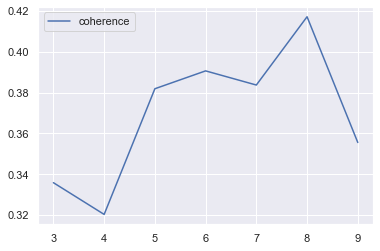

In [70]:
#coherence score vs number of topics 
sns.set()
sns.lineplot(np.arange(3, 10), coherence_list, label='coherence')

По результатм можно сделать вывод, что самым оптимальным является 8 тем. 
По распределению слов в темах можно предположить следующие названия: 
1. цско  
2. оформление кредита   
3. ?????? 
4. ипотека/закладная по доверенности  
5. снятие денег/банкомат 
6. обращение в офис  
7. погашение задолженности по кредиту 
8. бонус-спасибо 

In [72]:
n_topics = 8
lda_model = gensim.models.LdaMulticore(doc_term_matrix, num_topics=n_topics, id2word = dictionary, passes=60)

In [73]:
#main topic in each query 
dominant_topics = [item[-1][0] for item in lda_model[doc_term_matrix]]

In [78]:
topics = pd.DataFrame()
topics['text'] = topic_data
topics['topic'] = dominant_topics
topics['score'] = data[data.bank_name == 'сбербанк']['score']
topics.columns = ['text', 'topic', 'score']

In [79]:
topics.head()

,text,topic,score
232,"[ , раз, обращаться, вопрос, списание, овердр...",4,NaN
233,"[возмутить, удивить, сложиться, ситуация, сбер...",7,NaN
234,"[знать, дождаться, сбер, провести, клиентский,...",7,NaN
235,"[здравствовать, возникнуть, следующий, проблем...",7,NaN
236,"[дорогой, друг, сбербанк, хотеться, дело, огро...",3,NaN


In [80]:
#correlation between score and topic? 
results = pd.crosstab(topics['topic'], topics['score'])
from scipy.stats import chi2_contingency
chi2 = chi2_contingency(results)
print(f'Chi-squared = {chi2[0]} with a p-value {chi2[1]}')

Chi-squared = 455.58017465961694 with a p-value 1.1781273625452775e-74


In [88]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(lda_model, doc_term_matrix, dictionary)

/Users/mariaisrafilova/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/mariaisrafilova/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/mariaisrafilova/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/mariaisrafilova/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/mariaisrafilova/opt/anaconda3

In [89]:
lda_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.133133  0.027927       1        1  29.069958
5      0.088189  0.029152       2        1  25.428945
0      0.132025  0.009508       3        1  17.215603
3      0.052027 -0.119188       4        1  15.912272
1      0.011178  0.094986       5        1   4.909222
6     -0.142966  0.137369       6        1   2.942575
7     -0.065630 -0.141552       7        1   2.751925
2     -0.207956 -0.038201       8        1   1.769500, topic_info=             Term         Freq        Total Category  logprob  loglift
21          карта  4443.000000  4443.000000  Default  30.0000  30.0000
439        кредит  1455.000000  1455.000000  Default  29.0000  29.0000
11         деньга  2470.000000  2470.000000  Default  28.0000  28.0000
1            банк  5027.000000  5027.000000  Default  27.0000  27.0000
44       сбербанк  4289.000000  4289.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
1493  электронный     8.064055   155.771811   Topic8  -6.2304   1.0735
3154        форма     7.347344   104.930961   Topic8  -6.3234   1.3755
138        филиал     7.483132   128.578351   Topic8  -6.3051   1.1906
258      документ     8.591791   799.090286   Topic8  -6.1670  -0.4982
461        делать     7.225939   418.516870   Topic8  -6.3401  -0.0246

[632 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.298183         
0         2  0.280394         
0         3  0.083864         
0         4  0.269382         
0         5  0.056757         
...     ...       ...      ...
2940      7  0.635581  этажный
2316      4  0.959592     юлия
7852      2  0.246428   якутск
7852      7  0.616071   якутск
3062      6  0.755776    яркий

[1604 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 6, 1, 4, 2, 7, 8, 3])